1. Install AWS CLI v2
    - option 1: [docker](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-docker.html)
    - option 2: [linux](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-linux.html)
2. Create an IAM user with administrator permissions
3. Configure AWS CLI
    - **Access key** - It is a combination of an Access Key ID and a Secret Access Key. Together, they are referred to as Access key. You can generate an Access key from the AWS IAM service, and specify the level of permissions (authorization) with the help of IAM Roles.
    - **Default AWS Region** - It specifies the AWS Region where you want to send your requests by default.
    - **Default output format** - It specifies how the results are formatted. It can either be a json, yaml, text, or a table.
    - **Profile** - A collection of settings is called a profile. The default profile name is default, however, you can create a new profile using the aws configure --profile new_name command. A sample command is given below
    



## Installing AWS CLI v2


1. To run AWS CLI version 2 Docker image and execute a aws command:
> docker run --rm -it amazon/aws-cli *command*

    - --rm Specifies to clean up the container after the command exits.

    - -it Specifies to open a pseudo-TTY with stdin. This enables you to provide input to the AWS CLI version 2 while it's running in a container, for example, by using the aws configure and aws help commands. 
    
    
2. To allow the container aws CLI access to the host file system
> docker run --rm -it -v ~/.aws:/root/.aws amazon/aws-cli *command*

    - Because the AWS CLI version 2 is run in a container, by default the CLI can't access the host file system, which includes configuration and credentials. To share the host file system, credentials, and configuration to the container, mount the host system’s ~/.aws directory to the container at /root/.aws with the -v flag to the docker run command. This allows the AWS CLI version 2 running in the container to locate host file information.
    
3. Create an alias for running AWS CLI v2 docker image:
> alias aws='docker run --rm -it -v ~/.aws:/root/.aws -v \$(pwd):/aws amazon/aws-cli'

4. Check whether the alias is working:
> aws --version



## Create IAM user with administrator permissions




1. Go to IAM > User and add a new user
2. Select programmatic access for access type and set the permission by attaching existing policy-AdministratorAccess
3. Save the Access key ID and the Secret Access Key of the created IAM user


## Configure the AWS CLI


1. To check the current configuration:
> aws configure list

2. To set the default profile credentials:
> aws configure --profile default

    - The command above will store the access key in a default file ~/.aws/credentials and store the profile in the ~/.aws/config file. Upon prompt, paste the copied access key (access key id and secret access key). Enter the default region as us-east-1 and output format as json

3. To store the config file in environment variable
> echo "export AWS_CONFIG_FILE='~/.aws/config' " >> ~/.zshrc


4. To store the credentials in environment variable
> echo "export AWS_SHARED_CREDENTIALS_FILE='~/.aws/credentials'" >> ~/.zshrc



## After the initial setup


1. start docker
> sudo service docker start

2. check what containers you have
> docker ps -a

3. check your aws users
> aws iam list-users

4. check your current configuration
> aws configure list

5. if you need to change configuration
> aws configure set default.region us-east-2

    - aws configure set <varname> <value> [--profile profile-name]
    - or edit the config files in /.aws
    
    
4. continue with your aws cli


## Create EMR cluster


example:
> aws emr create-cluster --name (cluster_name) \\  
--use-default-roles --release-label emr-5.28.0  \\  
--instance-count 3 --applications Name=Spark Name=Zeppelin \\  
--bootstrap-actions Path="s3://bootstrap.sh" \\  
--ec2-attributes KeyName=(your permission key name) \\  
--instance-type m5.xlarge --log-uri s3:///emrlogs/  

- --name : You can give any name of your choice. This will show up on your AWS EMR UI.
- --release-label: This is the version of EMR you’d like to use.
- --instance-count: Annotates instance count. One is for the primary, and the rest are for the secondary. For example, if --instance-count is given 4, then 1 instance will be reserved for primary, then 3 will be reserved for secondary instances.
- --applications: List of applications you want to pre-install on your EMR at the launch time
- --bootstrap-actions: The Path attribute provides the path to a file (residing in S3 or locally) that contains a script that runs during a bootstrap action. The script may set environmental variables in all the instances of the cluster. This file must be accessible to each instance in the cluster.
- --ec2-attributes KeyName: Specify your permission key name, for example, if it is MyKey.pem, just specify MyKey for this field
- --instance-type: Specify the type of instances you want to use. Detailed list can be accessed here, but find the one that can fit your data and your budget.
- --log-uri: S3 location to store your EMR logs in. This log can store EMR metrics and also the metrics/logs for submission of your code.


[Here are references](https://awscli.amazonaws.com/v2/documentation/api/latest/reference/emr/create-cluster.html)  

### prerequisite for creating a emr cluster

- AWS CLI
- AWS IAM user (key/secret stored in aws cli configuration files)
- EC2 login key-pairs (created on aws ec2 and downloaded the pem file)

### create an EMR cluster  

- create cluster
> aws emr create-cluster \                                                            
            --name sparkify \
            --use-default-roles \
            --release-label emr-5.20.0 \
            --instance-count 4 \
            --applications Name=Spark Name=Hive \
            --ec2-attribute KeyName=YOUR_EC2_KEY_FILE_NAM,SubnetId=YOUR_SUBNET_ID\
            --instance-type m5.xlarge

    - YOUR_EC2_KEY_FILE_NAME is the pem file name. **YOUR_SUBNET_ID should be choosen from your aws VPC and it is necessary for using emr notebook**. After successfully launching the EMR cluster, the master and core (slave) EC2 instances will launch automatically. This can be seen on aws EC2 dashboard.
- save the output cluster temporary variable
> export CLUSTERID=YOUR_CLUSTER_ID

### change security group  

This step only needs to be done once. Ultimately, we want to log in to the master EC2 instance of the EMR cluster using SSH protocol. For that, we need to enable the security groups setting of the master EC2 instance to accept incoming SHH protocol from our local computer.
- go to the EC2 dashboard → Security Groups service

- select master node and edit
- edit enbound rules 
    - add a new rule with SSH and My IP settings
    - add another rule with Custom TCP, port 18080 and My IP settings (This is for accessing Spark UI of master node from my local browser)

### Verify the connection to the master node

- get the Master Public DNS name
> aws emr describe-cluster --cluster-id $CLUSTERID

- save the master public DNS to a temporary variable
> export dns=YOUR_MASTER_NODE_DNS

- connect to the master node
> ssh -i YOUR_EC2_KEY_PATH hadoop@$DNS

- say yes to establish the connection 
- now you verified the connection and can exit

### create SSH tunnel

[here](https://docs.aws.amazon.com/emr/latest/ManagementGuide/emr-ssh-tunnel.html)

- **create an SSH tunnel to the Master Node Using Dynamic Port Forwarding.** (Leave it like that and open a new terminal)
>  ssh -i keys/spark-cluster.pem -ND 8156 hadoop@$DNS

- copy the EC2 private key (.pem file) to the master node (optional??)
>  scp -i YOUR_EC2_KEY_PATH YOUR_EC2_KEY_PATH hadoop@$DNS:/home/hadoop/

- configure proxy setting
    - add SwitchyOmega extension to Chrome
    - create new profile in SwitchyOmega and select PAC profile type
    - save the following script in the new file
        - function FindProxyForURL(url, host) {if (shExpMatch(url, "*ec2*.amazonaws.com*")) return 'SOCKS5 localhost:8156';if (shExpMatch(url, "*ec2*.compute*")) return 'SOCKS5 localhost:8156';if (shExpMatch(url, "http://10.*")) return 'SOCKS5 localhost:8156'; if (shExpMatch(url, "*10*.compute*")) return 'SOCKS5 localhost:8156'; if (shExpMatch(url, "*10*.amazonaws.com*")) return 'SOCKS5 localhost:8156'; if (shExpMatch(url, "*.compute.internal*")) return 'SOCKS5 localhost:8156'; if (shExpMatch(url, "*ec2.internal*")) return 'SOCKS5 localhost:8156'; return 'DIRECT';}

### view Spark UI hosted on the EMR Clusters
> start http://$DNS:18080/

Alternatively, go to aws emr console > clusters and click on the hyperlink of Persistent user interface

### Submit scripts on EMR cluster

- connect to the master node as step 4

- write your python script or copy your scripts from local:
> scp -i PATH_TO_YOUR_EC2_KEY PATH_TO_SCRIPT hadoop@$DNS:/home/hadoop/

- submit the script as follow
> usr/bin/spark-submit --master yarn PATH_TO_THE_SCRIPT

- go to Spark UI and refresh it to get details on that app, such as the event log

### terminate the cluster

- aws emr terminate-clusters --cluster-ids $CLUSTERID

### make sure it is terminated 

- aws emr describe-cluster --cluster-id $CLUSTERID

### stop the docker service

## Spark Web UI


Spark has built-in UI that can be access from web browser. The Web UI only shows pages related to current Spark jobs that are running.

### DAG > Stages > tasks

- tasks are the steps that the individual worker nodes are assigned
- at each stage, the worker node divides up the input data and runs the task for that stage

### Connecting to the Spark Web UI

- transferring private data 
    - uses SSH (Secure SHell)
    - port 22 for SSH
    
- transferring HTML data for a webpage
    - uses HTTP (Hyper Text Transfer Protocol)
    - port 80 for HTTP
    
Important ports used by Spark:

- port 7077: is used by master node to communicate with worker nodes
- port 4040: shows active spark jobs
- port 8080: Web UI for the master node is on port 8080

Other protocols includes:

- Transmission Control Protocol (TCP): TCP is a popular communication protocol which is used for communicating over a network. It divides any message into series of packets that are sent from source to destination and there it gets reassembled at the destination.
- Internet Protocol (IP): IP is designed explicitly as addressing protocol. It is mostly used with TCP. The IP addresses in packets help in routing them through different nodes in a network until it reaches the destination system. TCP/IP is the most popular protocol connecting the networks.
- Hyper Text Transfer Protocol Secure (HTTPS): HTTPS is abbreviated as Hyper Text Transfer Protocol Secure is a standard protocol to secure the communication among two computers one using the browser and other fetching data from web server. HTTP is used for transferring data between the client browser (request) and the web server (response) in the hypertext format, same in case of HTTPS except that the transferring of data is done in an encrypted format. So it can be said that https thwart hackers from interpretation or modification of data throughout the transfer of packets.

### Types of Spark functions

There are two types of functions in Spark:
1. Transformations
2. Actions


Spark uses lazy evaluation to evaluate RDD and dataframe. Lazy evaluation means the code is not executed until it is needed. The action functions trigger the lazily evaluated functions.

For example,


<code>df = spark.read.load("some csv file")    
df1 = df.select("some column").filter("some condition")
df1.write("to path") 
</code>

In this code, **select** and **filter** are transformation functions, and **write** is an action function.
If you execute this code line by line, the second line will be loaded, but you will not see the function being executed in your Spark UI. When you actually execute using action write, then you will see your Spark program being executed.

### View Log Data
We can configure the logging level in two different ways:
1. edit Log4j properties file in the comp directory of master node
2. set it in Spark context
    - <code>spark = SparkSession.builder.config('local').getOrCreate()    
    spark.sparkContext.setLogLevel("ERROR")</code>
    

[here](https://spark.apache.org/docs/latest/configuration.html) for Spark configuration


## Debugging


### accumulator
example,

<code>from pyspark.sql import SparkSession
from pyspark.context import SparkContext
spark = SparkSession.builder.config('local').getOrCreate()
incorrect_records = SparkContext.accumulator(0,0)
def count_incorrect():
    global incorrect_records
    incorrect_records +=1
from spark.sql.function import udf
correct_ts = udf(lambda x: 1 if x.isdigit() else count_incorrect())
logs = logs.withColumn("ts_digit", correct_ts(logs.ts))
logs.collect() # action
print(incorrect_records.value)</code>


### broadcast
example,

<code>from pyspark.context import SparkContext
    
sc = SparkContext('local[*]', 'pyspark')
my_dict = {"item1": 1, "item2": 2, "item3": 3, "item4": 4} 
my_list = ["item1", "item2", "item3", "item4"]
my_dict_bc = sc.broadcast(my_dict)
def my_func(letter):
    return my_dict_bc.value[letter] 
my_list_rdd = sc.parallelize(my_list)
result = my_list_rdd.map(lambda x: my_func(x)).collect()
print(result)</code>
    
### data skew
a major headache in big data
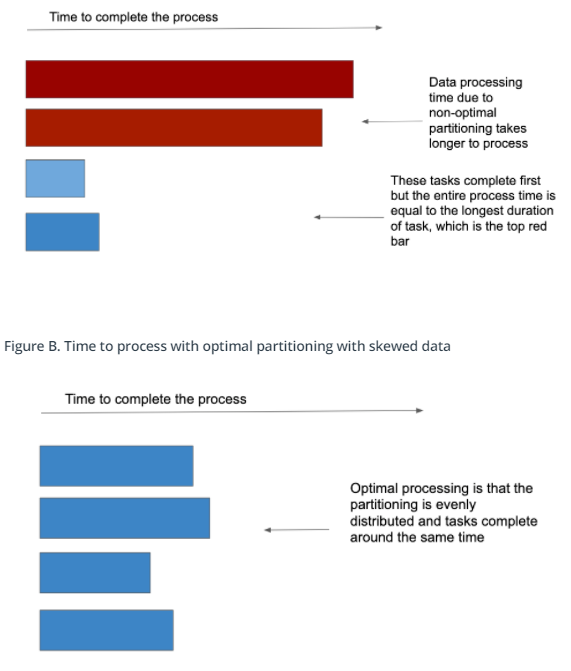
solutions:
    - use alternate columns that are more normally distributed
        - e.g. instead of year column, use issued_date column as partitioning column
    - make composite keys
        - e.g. make a new composite key (issue_date + state, 2017-05-02-NY) and use it to partition the data
    - partition by number of Spark workers
        - e.g.  If you know the number of your workers for Spark, then you can easily partition the data by the number of workers spark_df.repartition(number_of_workers) to repartition your data evenly across your workers